<h1>Определение связи наличия гарантийного ремонта при техническом обслуживании автомобиля<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-исследовательский-анализ" data-toc-modified-id="Загрузка-данных-и-исследовательский-анализ-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных и исследовательский анализ</a></span></li><li><span><a href="#Применение-моделей-и-подбор-гиперпараметров-с-помощью-Pipeline" data-toc-modified-id="Применение-моделей-и-подбор-гиперпараметров-с-помощью-Pipeline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Применение моделей и подбор гиперпараметров с помощью Pipeline</a></span></li><li><span><a href="#Использование-CatBoostClassifier" data-toc-modified-id="Использование-CatBoostClassifier-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Использование CatBoostClassifier</a></span></li><li><span><a href="#Использование-BaggingClassifier" data-toc-modified-id="Использование-BaggingClassifier-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Использование BaggingClassifier</a></span></li><li><span><a href="#Использование-LGBMClassifier" data-toc-modified-id="Использование-LGBMClassifier-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Использование LGBMClassifier</a></span></li></ul></div>

In [180]:
import pandas as pd
import datetime
import polars as pl
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=4)
import catboost
import sklearn
import shap
import phik
import lightgbm

from numpy import mean
from numpy import std
from matplotlib import pyplot
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from datetime import datetime
from catboost import MetricVisualizer
from catboost import cv
from catboost import * 
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve
from catboost.utils import select_threshold

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_score)
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, SVR
from sklearn.ensemble import BaggingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.linear_model import (
    LogisticRegression,
    LinearRegression,
    Lasso,
    Ridge
)

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    precision_score,
    precision_recall_curve,
    make_scorer,
    average_precision_score
)

In [181]:
def hist_plot(df, count_list, figsize):
    row = math.ceil(len(count_list))
    fig, axes = plt.subplots(row, 2, figsize=(12, figsize))
    plt.suptitle('Распределение по количественным признакам',
                 x=0.5,
                 y=0.9,
                 fontsize=12,
                 fontweight='bold')    
    for i, j in enumerate(count_list):
        sns.histplot(data = df, x=j, ax=axes[i, 0],
                     kde=True,
                     line_kws = {'linestyle':'dashed',
                                 'linewidth':'1'},
                     color='#9BCD9B')
        sns.boxplot(data = df, x=j, ax=axes[i, 1],
                     color='#9BCD9B',
                     linewidth=0.5,
                     width=0.5,
                     medianprops={"color": "r", "linewidth": 1})

In [182]:
def cat_plot_pie(df, kat_list):
    row = math.ceil(len(kat_list)/2)
    fig, ax = plt.subplots(nrows = row, ncols = 2, figsize = (12, 8))
    plt.suptitle('Распределение по категоральным признакам',
                 x=0.5,
                 y=0.94,
                 fontsize=12,
                 fontweight='bold')
    k = 0
    for r in range(row):
        for c in range(2):
            ax[r,c].pie(df[kat_list[k]].dropna().value_counts(),
                        labels = df[kat_list[k]].dropna().value_counts().index,
                        startangle=90,
                        autopct = '%1.1f%%',
                        colors=sns.color_palette('Set3')
                        )
            ax[r,c].set_title(kat_list[k])
            k += 1
            if k==len(kat_list):
                break

In [183]:
def bootstrap_metric(x, y, metric_fn, samples_cnt=1000, alpha=0.05, random_state=42):
    size = len(x)
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)

        x_boot = x[poses]
        y_boot = y[poses]

        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val

    return b_metric

In [184]:
def get_models():
    models = dict()
    trees = [10, 50, 100, 500, 1000]
    for n in trees:
        models[str(n)] = LGBMClassifier(n_estimators=n)
    return models

def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_train_encoded, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores

def get_models():
    models = dict()
    for i in range(1, 11):
        models[str(i)] = LGBMClassifier(max_depth=i, num_leaves=2**i)
    return models

def get_models():
    models = dict()
    rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
    for r in rates:
        key = '%.4f' % r
        models[key] = LGBMClassifier(learning_rate=r)
    return models

def get_models():
    models = dict()
    types = ['gbdt', 'dart', 'goss']
    for t in types:
        models[t] = LGBMClassifier(boosting_type=t)
    return models

## Загрузка данных и исследовательский анализ

In [4]:
df = pd.read_excel('/Users/alexfil/Desktop/git_hub/CatBoost/repair_warranty/repair_train.xlsx')
display(df.head(5), df.shape)

,maintenance,mileage,region,model,expl_days,month_repair,season_repair,target
0,S-03,45366,SFE,BD,975,5,spring,1
1,S-08,112000,MOW,CD,1141,5,spring,1
2,S-11,76627,NW,QB,3935,12,winter,0
3,S-03,45217,MOW,QLE,939,12,winter,0
4,S-10,79204,MOW,JD,3621,12,winter,0


(228953, 8)

In [5]:
df.isna().sum()

maintenance      0
mileage          0
region           0
model            0
expl_days        0
month_repair     0
season_repair    0
target           0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228953 entries, 0 to 228952
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   maintenance    228953 non-null  object
 1   mileage        228953 non-null  int64 
 2   region         228953 non-null  object
 3   model          228953 non-null  object
 4   expl_days      228953 non-null  int64 
 5   month_repair   228953 non-null  int64 
 6   season_repair  228953 non-null  object
 7   target         228953 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 14.0+ MB


In [7]:
num_col_names = ['mileage', 'expl_days', 'month_repair']
cat_col_names = ['maintenance', 'region', 'model', 'season_repair']

In [8]:
maintenance = ['PDI', 'S-01', 'S-02', 'S-03', 'S-04', 'S-05', 'S-06', 'S-07', 'S-08', 'S-09', 'S-10']

In [9]:
df = df.query('0 < expl_days < 2000 & mileage < 150000 & maintenance in @maintenance')

In [10]:
df.shape

(191671, 8)

In [11]:
df[num_col_names].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
mileage,191671.0,56020.17,29901.22,0.0,32191.0,51179.0,74701.0,149996.0
expl_days,191671.0,1136.43,416.38,1.0,800.0,1092.0,1458.0,1999.0
month_repair,191671.0,6.14,3.28,1.0,3.0,6.0,9.0,12.0


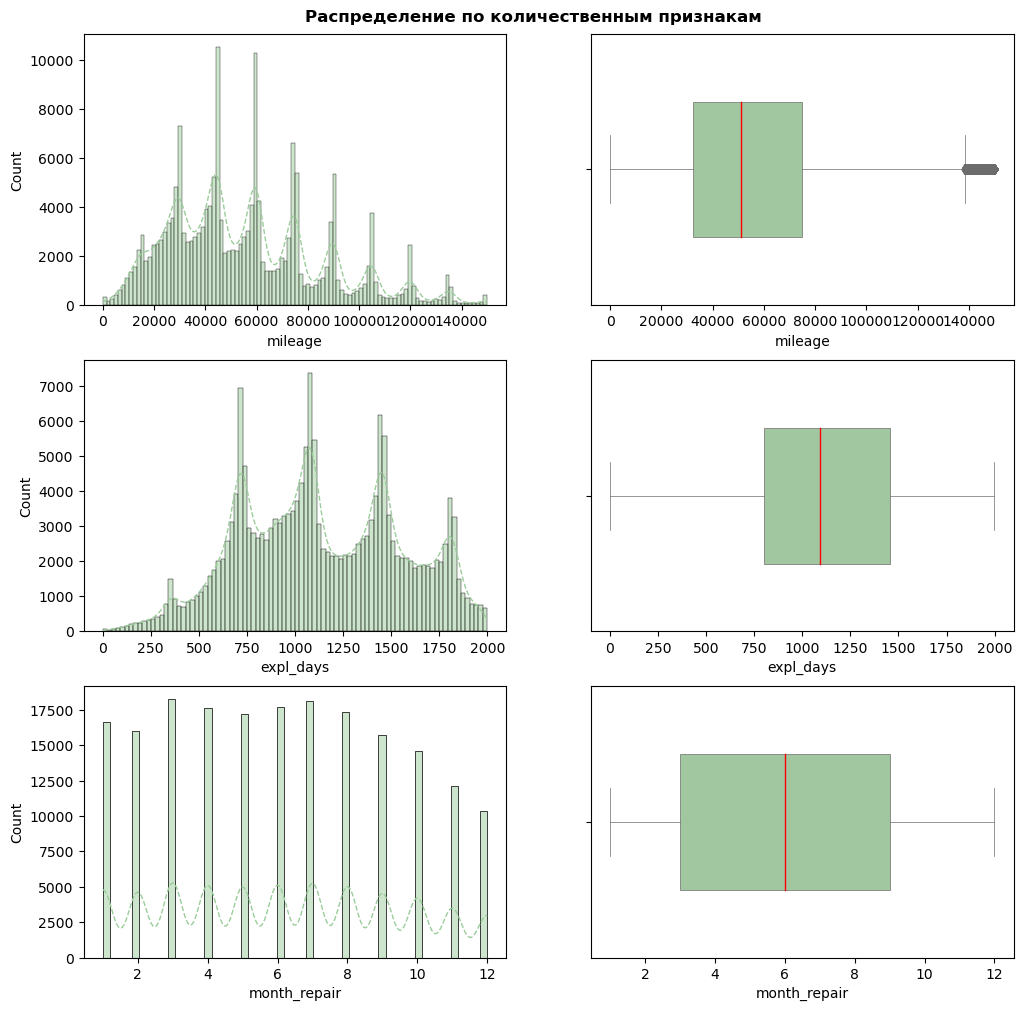

In [12]:
hist_plot(df, num_col_names, 12)

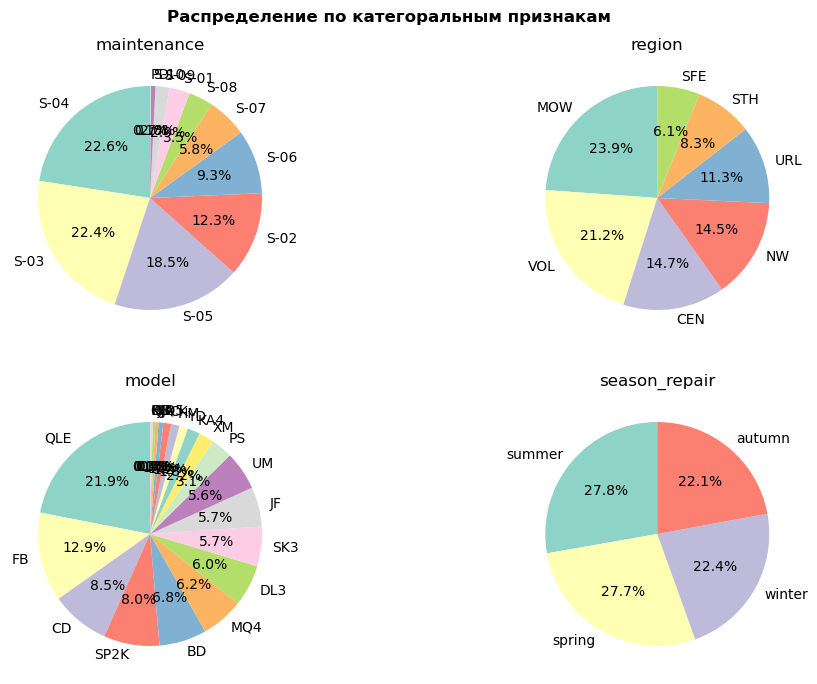

In [13]:
cat_plot_pie(df, cat_col_names)

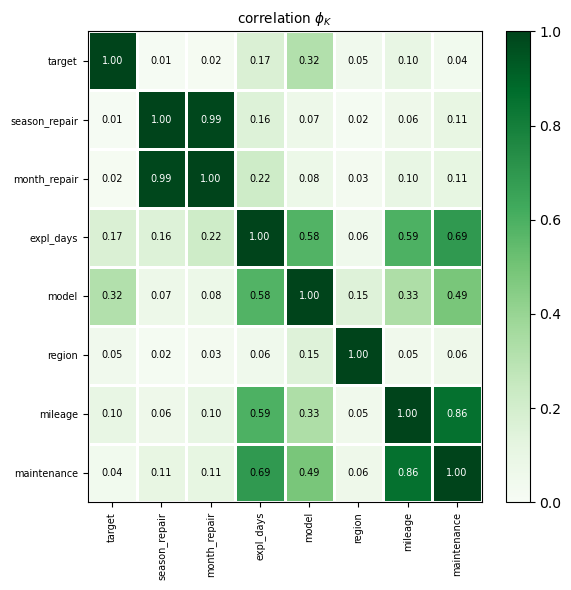

In [14]:
phik_overview = phik_matrix(df.loc[:, ~df.columns.isin(['vin'])], interval_cols=num_col_names, verbose=False)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=0.7,
    figsize=(6, 6)
) 

## Применение моделей и подбор гиперпараметров с помощью Pipeline

In [15]:
X = df.drop(['month_repair', 'target'], axis=1)
y = df['target']

In [16]:
cat_features = X.select_dtypes(exclude='number').columns.tolist()
display(cat_features)

['maintenance', 'region', 'model', 'season_repair']

In [17]:
X.columns

Index(['maintenance', 'mileage', 'region', 'model', 'expl_days',
       'season_repair'],
      dtype='object')

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [19]:
ohe_columns = ['region', 'model', 'season_repair']
ord_columns = ['maintenance']
num_columns = ['mileage', 'expl_days']

In [20]:
ohe_pipe = Pipeline(
    [(
        'simpleImputer_ohe',
        SimpleImputer(
            missing_values=np.nan,
            strategy='most_frequent'
        )
    ),
     (
         'ohe',
         OneHotEncoder(
             drop='first',
             handle_unknown='ignore',
             sparse=False
         )
     )
    ]
)

In [21]:
X['maintenance'].unique()

array(['S-03', 'S-08', 'S-04', 'S-07', 'S-02', 'S-05', 'S-01', 'S-06',
       'S-10', 'S-09', 'PDI'], dtype=object)

In [23]:
ord_pipe = Pipeline(
    [(
        'simpleImputer_before_ord',
        SimpleImputer(
            missing_values=np.nan,
            strategy='most_frequent'
        )
    ),
     (
         'ord',
         OrdinalEncoder(
              categories=[
                  ['PDI', 'S-01', 'S-02', 'S-03', 'S-04', 'S-05', 'S-06', 'S-07', 'S-08', 'S-09', 'S-10']
                  ], 
                handle_unknown='use_encoded_value',
             unknown_value=np.nan
            )
        ),
     (
         'simpleImputer_after_ord',
         SimpleImputer(
             missing_values=np.nan,
             strategy='most_frequent'
         )
     )
    ]
)

In [24]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [25]:
pipe_final_quit = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=42))
])

In [26]:
param_grid_quit = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=42)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=42, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
   
]

In [27]:
randomized_search_quit = RandomizedSearchCV(
    pipe_final_quit,
    param_grid_quit,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

In [28]:
randomized_search_quit.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['region',
                                                                                'model',
                                                                                'season_repair']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleI...
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(C=4,
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [29]:
print('Лучшая модель и её параметры:\n\n', randomized_search_quit.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search_quit.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['region', 'model',
                                                   'season_repair']),
                                                 ('ord',
                                                  

In [30]:
best_model_quit = randomized_search_quit.best_estimator_['models']
best_model_preprocessor_quit = randomized_search_quit.best_estimator_['preprocessor']

In [31]:
X_valid_encoded = best_model_preprocessor_quit.transform(X_valid)
y_predict_valid = best_model_quit.predict(X_valid_encoded)

In [32]:
print(
    f'Метрика ROC-AUC на валидационной выборке: \
    {roc_auc_score(y_valid, best_model_quit.predict_proba(X_valid_encoded)[::,1])}'
)

Метрика ROC-AUC на валидационной выборке:     0.671006536188899


In [33]:
result_quit = pd.DataFrame(randomized_search_quit.cv_results_)
result_quit = result_quit[
    ['rank_test_score', 'param_models', 'mean_test_score', 'params']
    ].sort_values('rank_test_score') 

In [34]:
result_quit

,rank_test_score,param_models,mean_test_score,params
9,1,"LogisticRegression(C=4, penalty='l1', random_s...",0.672669,"{'preprocessor__num': StandardScaler(), 'model..."
0,2,"LogisticRegression(C=4, penalty='l1', random_s...",0.672668,"{'preprocessor__num': MinMaxScaler(), 'models_..."
1,3,"LogisticRegression(C=4, penalty='l1', random_s...",0.672668,"{'preprocessor__num': StandardScaler(), 'model..."
3,4,KNeighborsClassifier(),0.633090,"{'preprocessor__num': MinMaxScaler(), 'models_..."
5,5,KNeighborsClassifier(),0.622356,"{'preprocessor__num': StandardScaler(), 'model..."
2,6,DecisionTreeClassifier(random_state=42),0.589948,"{'preprocessor__num': StandardScaler(), 'model..."
8,7,DecisionTreeClassifier(random_state=42),0.583000,"{'preprocessor__num': MinMaxScaler(), 'models_..."
6,8,DecisionTreeClassifier(random_state=42),0.562903,"{'preprocessor__num': MinMaxScaler(), 'models_..."
7,9,DecisionTreeClassifier(random_state=42),0.560418,"{'preprocessor__num': StandardScaler(), 'model..."
4,10,DecisionTreeClassifier(random_state=42),0.551473,"{'preprocessor__num': 'passthrough', 'models__..."


In [35]:
acc = accuracy_score(y_valid, y_predict_valid)

In [36]:
acc

0.6896990692432906

In [37]:
cm = confusion_matrix(y_valid, y_predict_valid)

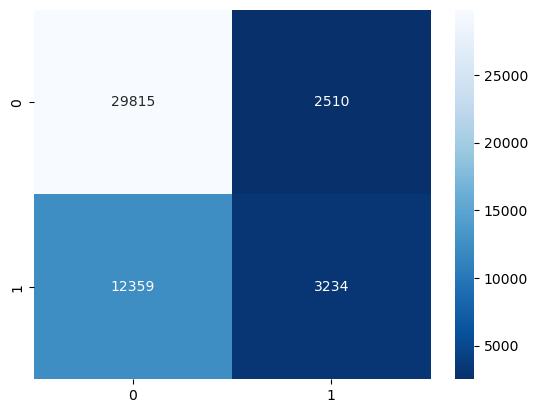

In [38]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
pass

In [39]:
recall = recall_score(y_valid, y_predict_valid)
precision = precision_score(y_valid, y_predict_valid)

In [40]:
print(
    f'Метрика Recall на валидационной выборке: \
    {recall}')

Метрика Recall на валидационной выборке:     0.20740075674982364


In [41]:
print(
    f'Метрика Precision на валидационной выборке: \
    {precision}')

Метрика Precision на валидационной выборке:     0.5630222841225627


In [42]:
X_train_df = pd.DataFrame(
    best_model_preprocessor_quit.fit_transform(X_train),
    columns=best_model_preprocessor_quit.get_feature_names_out())
X_valid_df = pd.DataFrame(
    best_model_preprocessor_quit.transform(X_valid),
    columns=best_model_preprocessor_quit.get_feature_names_out())

In [43]:
display(X_train_df.shape, X_valid_df.shape)

(143753, 33)

(47918, 33)

In [44]:
coefficients = best_model_quit.coef_[0]

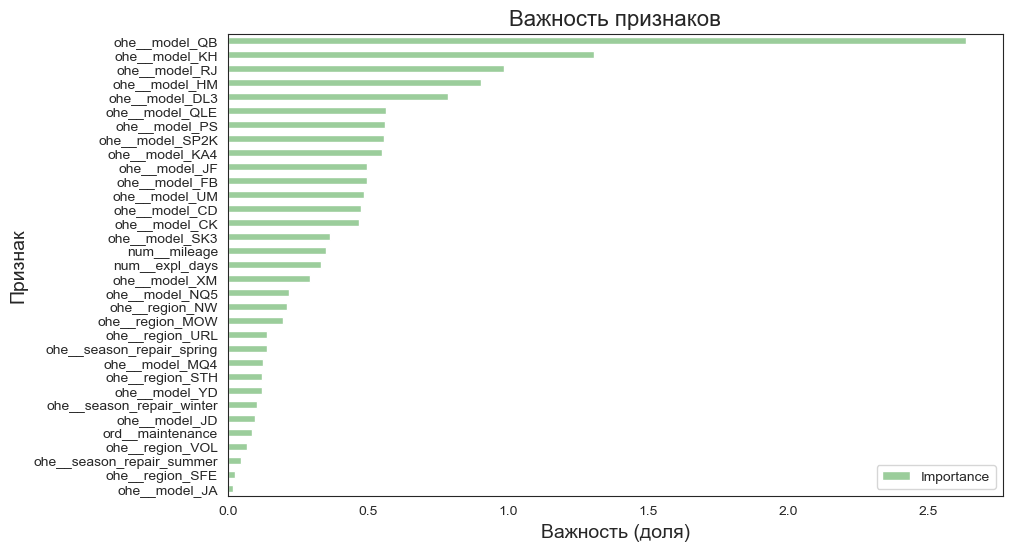

In [45]:
features_names = X_train_df.columns
feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': np.abs(coefficients)})
feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
ax = feature_importance.plot(x='Feature',
                             y='Importance',
                             kind='barh',
                             color='#9BCD9B',
                             figsize=(10, 6))
ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность (доля)', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)
plt.show()
pass

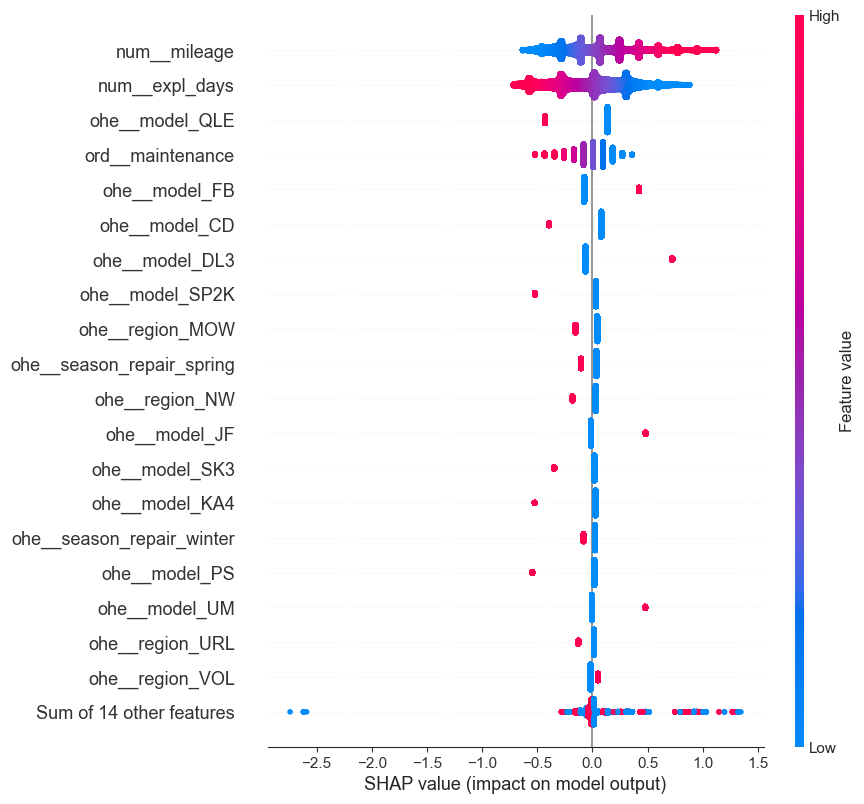

In [46]:
explainer =  shap.LinearExplainer(best_model_quit, X_train_df)
shap_values = explainer(X_train_df)
shap.plots.beeswarm(shap_values, max_display=20) 

In [47]:
test_df = pd.read_excel('/Users/alexfil/Desktop/git_hub/CatBoost/repair_warranty/repair_test.xlsx')

In [51]:
test_df = test_df.query('0 < expl_days < 2000 & mileage < 150000 & maintenance in @maintenance')

In [52]:
X_test = test_df.drop(['month_repair', 'target'], axis=1)
y_test = test_df['target']

In [53]:
X_test_encoded = best_model_preprocessor_quit.transform(X_test)
y_predict_test = best_model_quit.predict(X_test_encoded)

In [54]:
print(
    f'Метрика ROC-AUC на тестовой выборке: \
    {roc_auc_score(y_test, best_model_quit.predict_proba(X_test_encoded)[::,1])}'
)

Метрика ROC-AUC на тестовой выборке:     0.63203545815319


In [55]:
cm_test = confusion_matrix(y_test, y_predict_test)

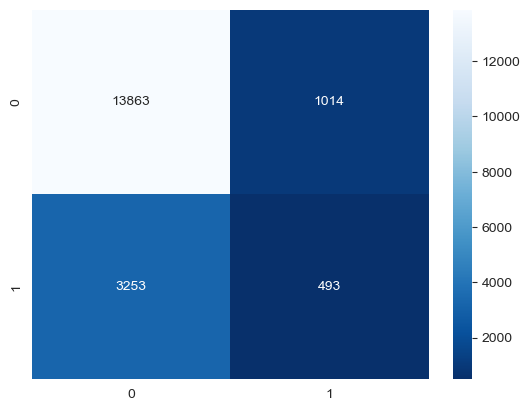

In [56]:
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues_r')
pass

## Использование CatBoostClassifier

In [58]:
model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.15
)

In [59]:
model = CatBoostClassifier(
    iterations=500,
    random_seed=40,
    learning_rate=0.15,
    custom_loss=['AUC', 'Accuracy']
)

model.fit(X_train, y_train,
         cat_features=cat_features,
         eval_set=(X_valid, y_valid),
          verbose=False,
          plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [60]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=500,
    random_seed=40,
    train_dir='learning_rate_0.7',
    custom_loss=['AUC', 'Accuracy']
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=500,
    random_seed=40,
    train_dir='learning_rate_0.01',
    custom_loss=['AUC', 'Accuracy']
)

model1.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    cat_features=cat_features,
    verbose=False,
    plot=True
)

model2.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [61]:
MetricVisualizer(['learning_rate_0.01', 'learning_rate_0.7']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [62]:
print(f'Tree count: {str(model2.tree_count_)}')

Tree count: 500


In [63]:
params = {
    'loss_function': 'Logloss',
    'iterations': 300,
    'custom_loss': 'AUC',
    'random_seed': 43,
    'learning_rate': 0.01
}

cv_data = cv(
    params=params,
    pool=Pool(X, label=y, cat_features=cat_features),
    fold_count=5, # split of 5 parts
    shuffle=True, # mix of data
    partition_random_seed=33,
    plot=True, 
    stratified=True, 
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5818498902
bestIteration = 299

Training on fold [1/5]

bestTest = 0.5797464191
bestIteration = 299

Training on fold [2/5]

bestTest = 0.5837797719
bestIteration = 299

Training on fold [3/5]

bestTest = 0.5814896303
bestIteration = 299

Training on fold [4/5]

bestTest = 0.5805486314
bestIteration = 299



In [64]:
cv_data.head(5)

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.690933,0.000010,0.690944,0.000012,0.668170,0.003188
1,1,0.688828,0.000072,0.688841,0.000075,0.671306,0.002504
2,2,0.686687,0.000091,0.686704,0.000080,0.674459,0.002999
3,3,0.684621,0.000088,0.684630,0.000069,0.674124,0.002941
4,4,0.682665,0.000116,0.682672,0.000105,0.674675,0.003464


In [65]:
best_value = np.max(cv_data['test-AUC-mean'])
best_iter = np.argmax(cv_data['test-AUC-mean'])
print('Best validation AUC score, stratified: {:.4f}+/-{:.3f} on step {}'.format(
best_value, cv_data['test-AUC-std'][best_iter], best_iter))

Best validation AUC score, stratified: 0.6905+/-0.003 on step 299


In [68]:
model_with_early_stop = CatBoostClassifier(
    iterations=500,
    random_seed=33,
    learning_rate=0.3,
    early_stopping_rounds=20
)

model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_valid, y_valid),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [69]:
model_with_early_stop=CatBoostClassifier(
    eval_metric='AUC', # select metric and print in first order
    iterations=500,
    random_seed=43,
    learning_rate=0.3,
    early_stopping_rounds=20)
model_with_early_stop.fit(
    X_train,y_train,
    cat_features=cat_features,
    eval_set=(X_valid, y_valid),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [70]:
print(model_with_early_stop.tree_count_)

124


In [71]:
eval_pool = Pool(X_valid, y_valid, cat_features=cat_features)
curve = get_roc_curve(model_with_early_stop, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

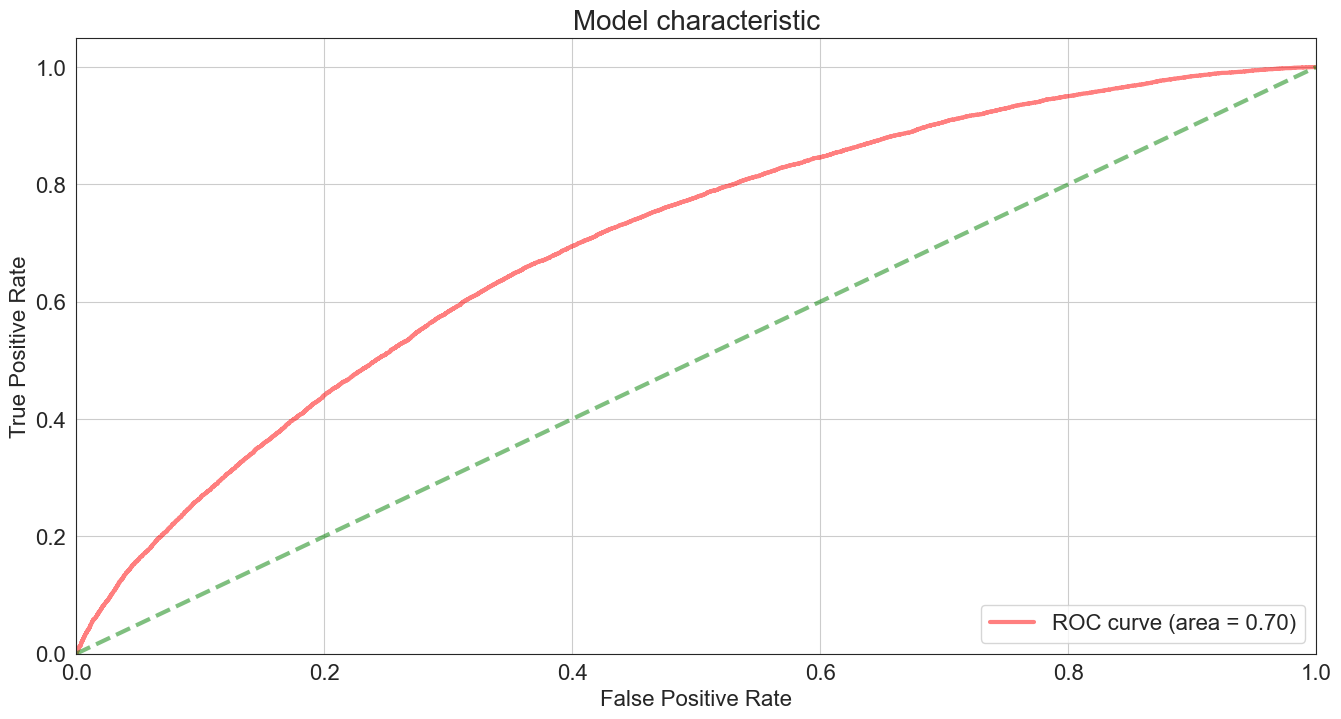

In [72]:
plt.figure(figsize=(16, 8))
lw=3

plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='g', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Model characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [73]:
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

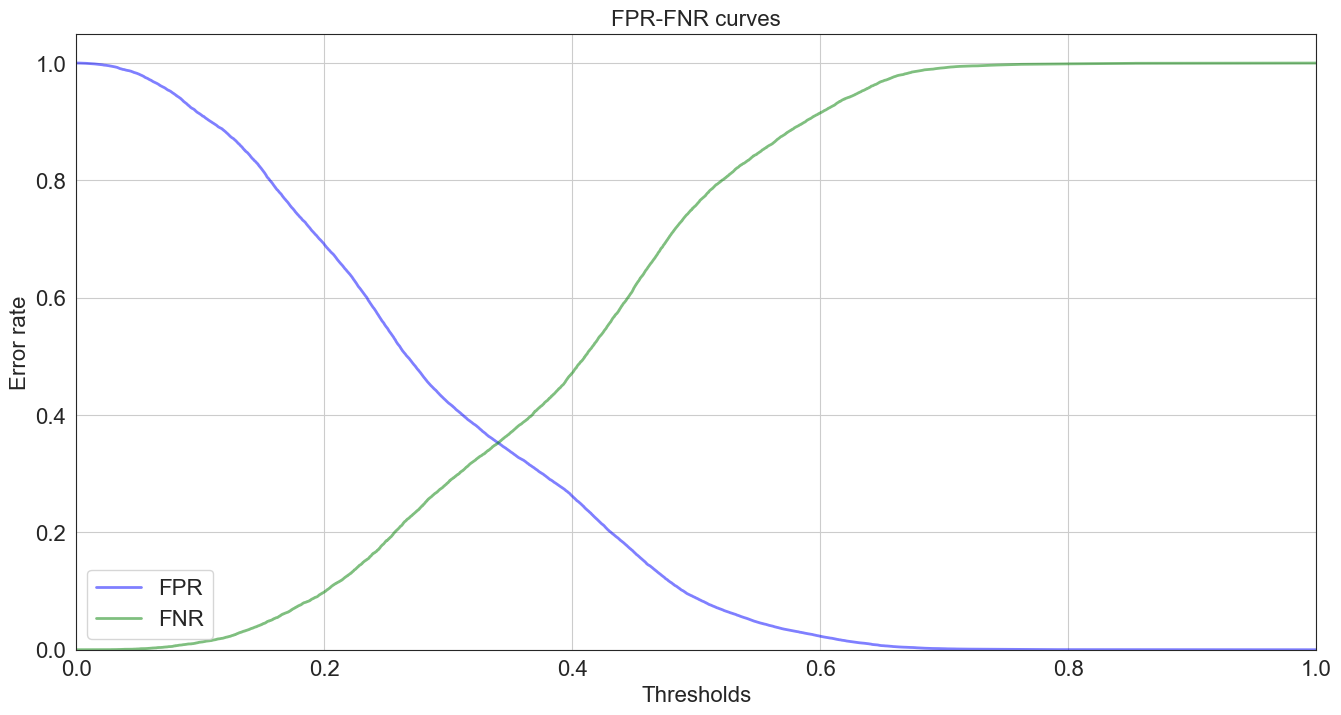

In [74]:
plt.figure(figsize=(16, 8))
lw=2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Thresholds', fontsize=16)
plt.ylabel('Error rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=16)
plt.legend(loc='lower left', fontsize=16)
plt.show()

In [75]:
print(select_threshold(model=model_with_early_stop, data=eval_pool, FNR=0.01))
print(select_threshold(model=model_with_early_stop, data=eval_pool, FPR=0.01))

0.09297980370844339
0.6395603728452957


In [76]:
print(model_with_early_stop.predict_proba(X_valid))

[[0.8571 0.1429]
 [0.8705 0.1295]
 [0.7625 0.2375]
 ...
 [0.7553 0.2447]
 [0.7481 0.2519]
 [0.7982 0.2018]]


In [77]:
model_with_early_stop.get_feature_importance(prettified=True)

,Feature Id,Importances
0,expl_days,32.503130
1,model,31.809870
2,mileage,16.835585
3,region,8.520992
4,maintenance,5.795251
5,season_repair,4.535172


In [78]:
pool1 = Pool(data=X_valid, label=y_valid, cat_features=cat_features)

In [79]:
shap_values=model.get_feature_importance(pool1, fstr_type='ShapValues')
print(shap_values.shape)

(47918, 7)


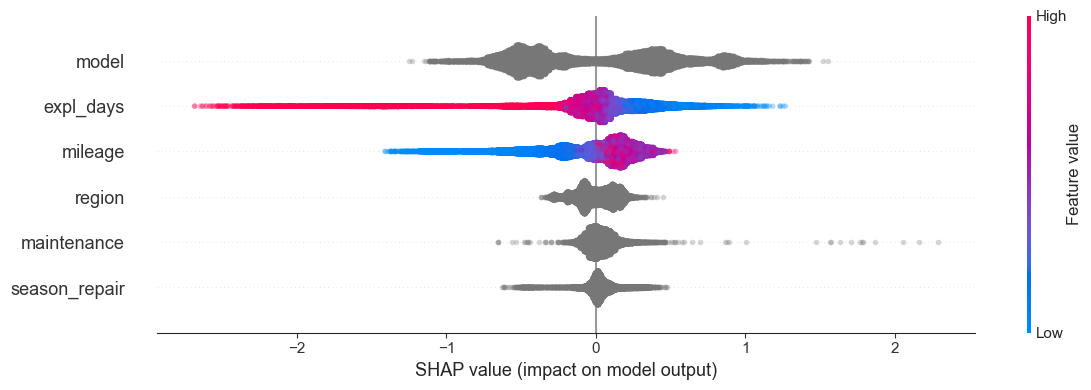

In [80]:
shap_valid = shap.TreeExplainer(model).shap_values(X_valid)

shap.summary_plot(shap_valid, X_valid,
                 max_display=12, plot_size=[12,4],
                  alpha=0.3
                 )

In [81]:
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    learning_rate=0.1,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton' 
)

tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_valid, y_valid),
    plot=True

)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [82]:
best_model = CatBoostClassifier(
    random_seed=63,
    iterations=int(tunned_model.tree_count_ * 1.2)
)

best_model.fit(
    X, y,
    cat_features=cat_features,
    verbose=100
)

Learning rate set to 0.126056
0:	learn: 0.6673220	total: 118ms	remaining: 1m 29s
100:	learn: 0.5738255	total: 7.42s	remaining: 47.9s
200:	learn: 0.5700212	total: 14.9s	remaining: 41s
300:	learn: 0.5676024	total: 23.6s	remaining: 35.4s
400:	learn: 0.5656485	total: 32s	remaining: 28.1s
500:	learn: 0.5638132	total: 39.4s	remaining: 19.8s
600:	learn: 0.5619488	total: 47.1s	remaining: 11.9s
700:	learn: 0.5602376	total: 54.6s	remaining: 4.05s
752:	learn: 0.5593373	total: 59s	remaining: 0us


## Использование BaggingClassifier

In [100]:
X_train_encoded = best_model_preprocessor_quit.transform(X_train)
X_valid_encoded = best_model_preprocessor_quit.transform(X_valid)

In [96]:
models = {}

logr_model = GridSearchCV(
    LogisticRegression(solver="liblinear", max_iter=100000),
    {"penalty": ("l1", "l2"), "C": [0.01, 0.1, 1, 10, 100]},
).fit(X_train_encoded, y_train)
models["LogReg"] = logr_model


# few objects in the leaf - poor estimates of class probabilities - the model is overtraining
dt_model = GridSearchCV(
    DecisionTreeClassifier(),
    {"max_depth": [1, 3, 5, 7, 10], "min_samples_leaf": [1, 3, 5, 10]},
).fit(X_train_encoded, y_train)
models["DT"] = dt_model

bagging_logr = BaggingClassifier(
    logr_model.best_estimator_, n_estimators=100, random_state=42
)
models["Bagging LogReg"] = bagging_logr


bagging_dt = BaggingClassifier(
    dt_model.best_estimator_, n_estimators=100, random_state=42
)
models["Bagging DT"] = bagging_dt

sqrt_features = int(np.sqrt(X_train_encoded.shape[1])) + 1

rsm_logreg = BaggingClassifier(
    logr_model.best_estimator_,
    n_estimators=100,
    bootstrap=False,
    max_features=sqrt_features,
    random_state=42,
)
models["RSM LogReg"] = rsm_logreg


rsm_dt = BaggingClassifier(
    dt_model.best_estimator_,
    n_estimators=100,
    bootstrap=False,
    max_features=sqrt_features,
    random_state=42,
)
models["RSM DT"] = rsm_dt

# Both Bagging and RSM
bag_rsm_logreg = BaggingClassifier(
    logr_model.best_estimator_,
    n_estimators=100,
    bootstrap=True,
    max_features=sqrt_features,
    random_state=42,
)
models["BagRSM LogReg"] = bag_rsm_logreg


bag_rsm_dt = BaggingClassifier(
    dt_model.best_estimator_,
    n_estimators=100,
    bootstrap=True,
    max_features=sqrt_features,
    random_state=42,
)
models["BagRSM DT"] = bag_rsm_dt

In [98]:
for name, model in models.items():
    model.fit(X_train_encoded, y_train)

In [101]:
predictions = {}

for name, model in models.items():
        y_pred = model.predict_proba(X_valid_encoded)[:, 1]
        predictions[name] = y_pred

In [113]:
boot_scores = {}

for name, y_pred in predictions.items():
    boot_score = bootstrap_metric(
        y_test.values,
        y_pred,
        metric_fn=lambda x, y: average_precision_score(y_true=x, y_score=y),
    )
    boot_scores[name] = boot_score

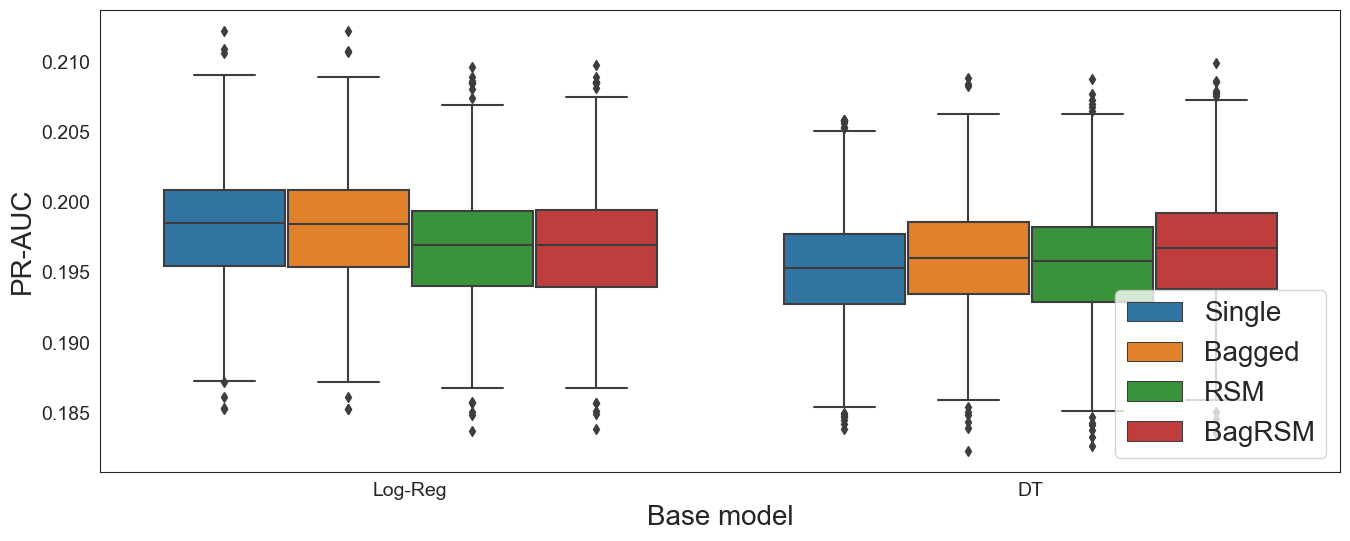

In [116]:
plt.figure(figsize=(16, 6))

base_models = ["Log-Reg", "DT"] * 4
ensemble_types = ["Single"] * 2 + ["Bagged"] * 2 + ["RSM"] * 2 + ["BagRSM"] * 2

dfs = []
for i, model_name in enumerate(boot_scores):
    df = pd.DataFrame(boot_scores[model_name], columns=["pr_auc"])
    df["base_model"] = base_models[i]
    df["ensemble_method"] = ensemble_types[i]
    dfs.append(df)

sns.boxplot(data=pd.concat(dfs), y="pr_auc", x="base_model", hue="ensemble_method")
plt.xlabel("Base model", size=20)
plt.ylabel("PR-AUC", size=20)
plt.legend(fontsize=20, loc="lower right")
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

## Использование LGBMClassifier

In [131]:
model = LGBMClassifier()

In [132]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [142]:
n_scores = cross_val_score(model, X_train_encoded, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

In [144]:
print('ROC-AUC: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

ROC-AUC: 0.699 (0.004)


In [160]:
models = get_models()

In [161]:
results, names = list(), list()

>10 0.690 (0.004)
>50 0.698 (0.004)
>100 0.699 (0.004)
>500 0.697 (0.004)
>1000 0.692 (0.004)


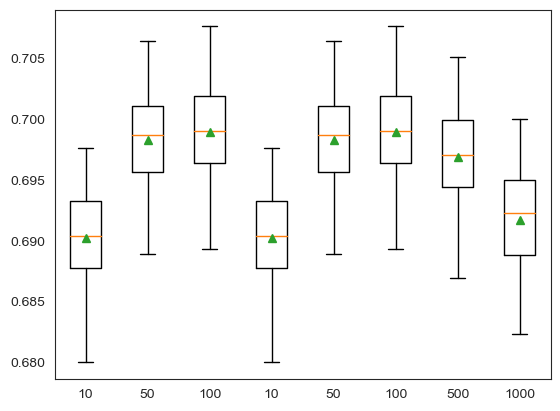

In [163]:
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [165]:
models = get_models()

In [166]:
results, names = list(), list()

[LightGBM] [Info] Number of positive: 42099, number of negative: 87278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129377, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325398 -> initscore=-0.729074
[LightGBM] [Info] Start training from score -0.729074
[LightGBM] [Info] Number of positive: 42099, number of negative: 87279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325395 -> initscore=-0.729086
[L

>1 0.671 (0.004)
[LightGBM] [Info] Number of positive: 42099, number of negative: 87278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129377, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325398 -> initscore=-0.729074
[LightGBM] [Info] Start training from score -0.729074
[LightGBM] [Info] Number of positive: 42099, number of negative: 87279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325395 -> inits

[LightGBM] [Info] Number of positive: 42099, number of negative: 87278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129377, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325398 -> initscore=-0.729074
[LightGBM] [Info] Start training from score -0.729074
[LightGBM] [Info] Number of positive: 42099, number of negative: 87279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325395 -> initscore=-0.729086
[L

[LightGBM] [Info] Number of positive: 42099, number of negative: 87279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325395 -> initscore=-0.729086
[LightGBM] [Info] Start training from score -0.729086
[LightGBM] [Info] Number of positive: 42100, number of negative: 87278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325403 -> initscore=-0.729051
[LightGBM] [Info] Start training from score -0.729051
[LightGBM] [

>2 0.687 (0.004)
>3 0.693 (0.004)
[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325395 -> initscore=-0.729086
[LightGBM] [Info] Start training from score -0.729086
[LightGBM] [Info] Number of positive: 42100, number of negative: 87278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325403 -> initscore=-0.729051
[LightGBM] [Info] Start training from score -0.729051
[LightGBM] [Info] Number of positive: 42099, number of negative: 87278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129377, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325398 -> initscore=-0.729074
[LightGBM] [Info] Start training from score -0.729074
[LightGBM] [Info] Number of positive: 42099, number of negative: 87279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325395 -> initscore=-0.729086
[LightGBM

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325395 -> initscore=-0.729086
[LightGBM] [Info] Start training from score -0.729086
[LightGBM] [Info] Number of positive: 42099, number of negative: 87278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129377, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325398 -> initscore=-0.729074
[LightGBM] [Info] Start training from score -0.729074
[LightGBM] [Info] Number of positive: 42099, number of negative: 87279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in

[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325395 -> initscore=-0.729086
[LightGBM] [Info] Start training from score -0.729086
[LightGBM] [Info] Number of positive: 42100, number of negative: 87278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325403 -> initscore=-0.729051
[LightGBM] [Info] Start training from score -0.729051
[LightGBM] [Info] Number of positive: 42099, number of negative: 87278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001572 seconds.
You can set `force_row_wise=true` to re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 42099, number of negative: 87279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325395 -> initscore=-0.729086
[LightGBM] [Info] Start training from score -0.729086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Number of positive: 42100, number of negative: 87278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325403 -> initscore=-0.729051
[LightGBM] [Info] Start training from score -0.729051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 42099, number of negative: 87278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, th

>4 0.696 (0.004)
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325395 -> initscore=-0.729086
[LightGBM] [Info] Start training from score -0.729086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

>5 0.698 (0.004)
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

>6 0.699 (0.004)
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

>7 0.700 (0.004)
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 42100, number of negative: 87278
[LightGBM] [Info] Auto-choosi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

>8 0.699 (0.004)
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 42099, number of negative: 87278
[LightGBM] [Info] Auto-choosi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 42100, number of negative: 87278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

>9 0.697 (0.004)
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 42100, number of negative: 87278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325403 -> initscore=-0.729051
[LightGBM] [Info] Start training from score -0.729051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 42099, number of negative: 87279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325395 -> initscore=-0.729086
[LightGBM] [Info] Start training from score -0.729086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325395 -> initscore=-0.729086
[LightGBM] [Info] Start training from score -0.729086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Start training from score -0.729086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 42100, number of negative: 87278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

>10 0.696 (0.004)


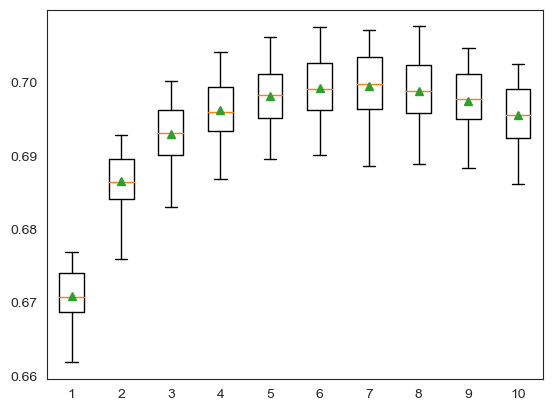

In [167]:
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>0.0001 0.682 (0.004)
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

>0.0010 0.683 (0.004)
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

>0.0100 0.691 (0.004)
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 42100, number of negative: 87278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325403 -> initscore=-0.729051
[LightGBM] [Info] Start training from score -0.729051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

>0.1000 0.699 (0.004)
>1.0000 0.669 (0.004)


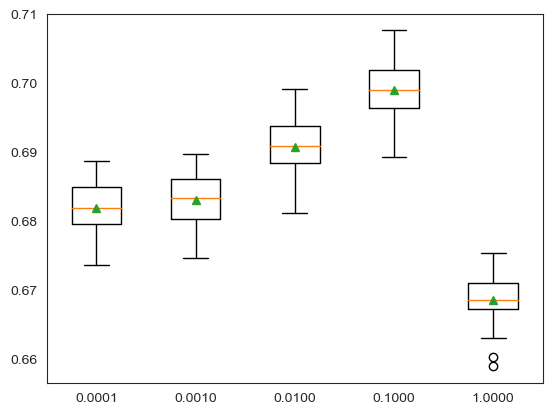

In [170]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

>gbdt 0.699 (0.004)
[LightGBM] [Info] Number of positive: 42099, number of negative: 87278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129377, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325398 -> initscore=-0.729074
[LightGBM] [Info] Start training from score -0.729074
[LightGBM] [Info] Number of positive: 42099, number of negative: 87279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325395 -> initscore=-0.729086
[LightGBM] [Info] Start training from score -0

>dart 0.699 (0.004)
[LightGBM] [Info] Start training from score -0.729086
[LightGBM] [Info] Number of positive: 42100, number of negative: 87278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325403 -> initscore=-0.729051
[LightGBM] [Info] Start training from score -0.729051
[LightGBM] [Info] Number of positive: 42099, number of negative: 87278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129377, number of used features: 32
[LightGB

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325398 -> initscore=-0.729074
[LightGBM] [Info] Start training from score -0.729074
[LightGBM] [Info] Number of positive: 42099, number of negative: 87279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 129378, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325395 -> initscore=-0.729086
[LightGBM] [Info] Start training from score -0.729086
[LightGBM] [Info] Number of positive: 42100, number of negative: 87278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

>goss 0.696 (0.004)


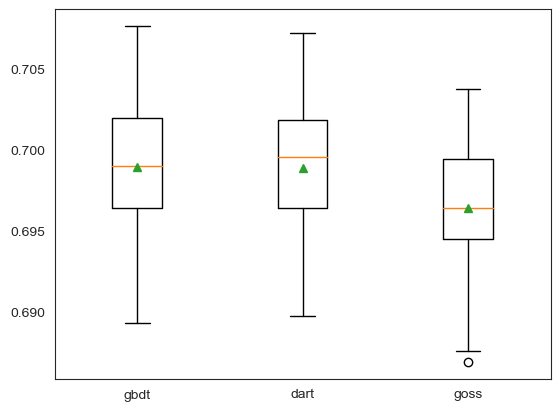

In [172]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [174]:
model_tuned = LGBMClassifier(boosting_type='dart',
                             learning_rate=0.1,
                             max_depth=7,
                             num_leaves=2**7,
                             n_estimators=100
                            )

In [175]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train_encoded, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('ROC-AUC: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

ROC-AUC: 0.696 (0.004)


In [177]:
model_tuned.fit(X_train_encoded, y_train)

[LightGBM] [Info] Number of positive: 46777, number of negative: 96976
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 143753, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325398 -> initscore=-0.729072
[LightGBM] [Info] Start training from score -0.729072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMClassifier(boosting_type='dart', max_depth=7, num_leaves=128)

In [178]:
y_predict_valid = model_tuned.predict(X_valid_encoded)

Метрика ROC-AUC на тестовой выборке:     0.6968676328626053


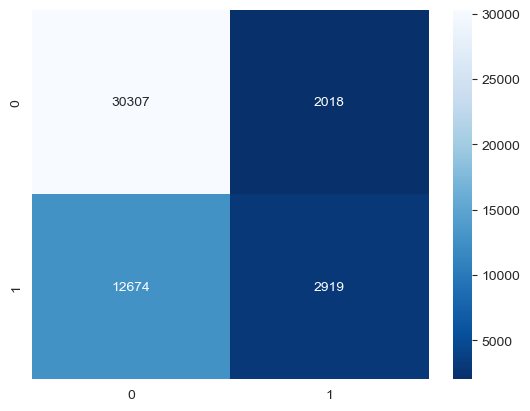

In [179]:
print(
    f'Метрика ROC-AUC на тестовой выборке: \
    {roc_auc_score(y_valid, model_tuned.predict_proba(X_valid_encoded)[::,1])}'
)
cm_test = confusion_matrix(y_valid, y_predict_valid)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues_r')
pass